In [3]:
import pandas as pd
import numpy as np
import scipy
import qpsolvers
import datetime as dt
from typing import Tuple
import sys
import time
sys.path.insert(1, '../src')

from helper_functions import *
from covariance import Covariance
from optimization import *
from optimization_data import OptimizationData
import qp_problems
import json
from constraints import Constraints
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from optimization_data import OptimizationData

plt.style.use(style='seaborn-v0_8')


/home/akaboshi/anaconda3/envs/finance/lib/python3.12/site-packages/qpsolvers/solvers/__init__.py:711: UserWarning: no QP solver found on your system, you can install solvers from PyPI by ``pip install qpsolvers[open_source_solvers]``
  warnings.warn(


In [4]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse


def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

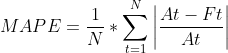

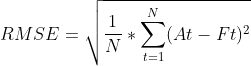

RMSE gives the differences between predicted and true values, whereas MAPE (%) measures this difference relative to the true values. For example, a MAPE value of 12% indicates that the mean difference between the predicted stock price and the actual stock price is 12%.

In [5]:
path = '/home/akaboshi/minhha/GeoFin/data/'  # Change this to your path


# Load data
return_series = pd.read_parquet(f'{path}usa_returns.parquet')
features = pd.read_parquet(f'{path}usa_features.parquet')

# Prepare data
series_id = return_series.columns[0]
y = return_series[series_id]
# Aggregating returns to monthly frequency
y_monthly = np.exp(np.log(1 + y).resample('M').sum()) - 1

X = features[features.index.get_level_values(1).isin([series_id])].reset_index(level=1, drop=True)
X.fillna(X.mean(), inplace=True)
X.fillna(0, inplace=True)


data = OptimizationData(align = True, lags = {'y': -1}, X = X, y = y_monthly)
# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = data.train_test_split(test_size = 0.2)

/tmp/ipykernel_3577/362034989.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_monthly = np.exp(np.log(1 + y).resample('M').sum()) - 1


RMSE of linear regression: 2.718060319414199
MAPE of linear regression: 18081.56270126829


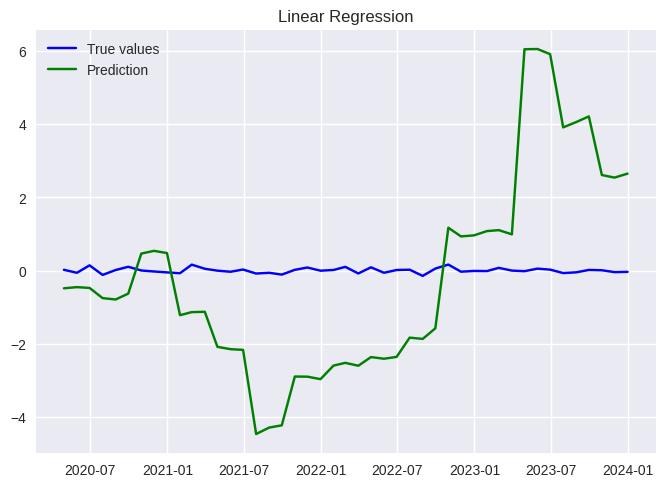

In [6]:
# --------------------------------------------------------------------------
# Regression
# --------------------------------------------------------------------------

# Using statsmodels

# X = sm.add_constant(X)
model = sm.OLS(y_train, X_train)
results = model.fit()
# print(results.summary())

# Assuming test_data is your new data
predictions = results.predict(X_test)
print(f'RMSE of linear regression: {calculate_rmse(y_test, predictions)}')
print(f'MAPE of linear regression: {calculate_mape(y_test, predictions)}')
plt.plot(y_test, color = 'blue')
plt.plot(predictions, color = 'green', alpha = 1)
plt.legend(["True values", "Prediction"])
plt.title('Linear Regression')
plt.show()

## Remarks 


Explanations for the poor performance of the Linear Regression 

* __Curse of dimensionality__: For training dataset, we have 183 samples and 153 features. The number of datapoints is small (in a suitably defined sense) relative to the intrinsic dimension of the data.


__Potential solutions__: 

--> Increase number of data points by segmenting the timeline in smaller slices. For example, monthly --> 2-week slice 

--> Dimension reduction: ACP 

--> Features selection: Using only influential, non-correlated features 

* __Non-linearity__ : Linear regression assumes linear relation between y and X, which might not be the case for stock features.  

* Na value imputation method: Mean --> 0 

In [7]:
from sklearn import decomposition

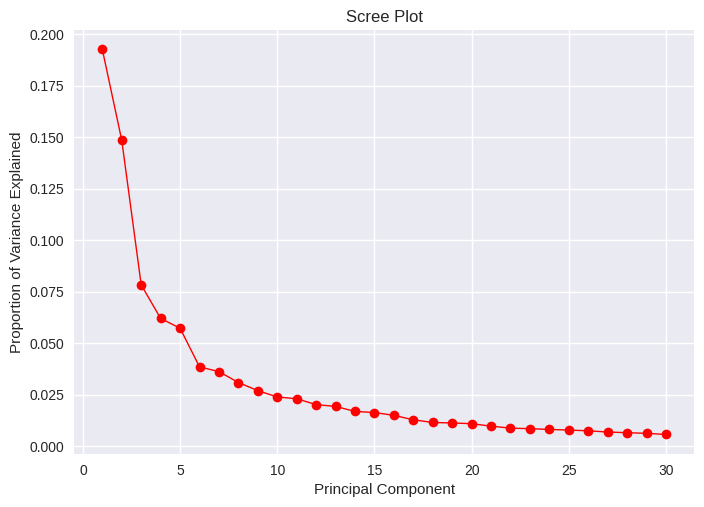

Cumulative Prop. Variance Explained by 30 is:  0.9272178764907512


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Scaling
x_scaled = StandardScaler().fit_transform(data['X'])

# Reduce from 4 to 3 features with PCA
nb_component = 30
pca = PCA(n_components = nb_component)

# Fit and transform data
pca_features = pca.fit_transform(x_scaled)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=1)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)

out_sum = np.cumsum(pca.explained_variance_ratio_)
print (f"Cumulative Prop. Variance Explained by {nb_component} is: ", out_sum[-1])


RMSE of linear regression: 0.07758389402148422
MAPE of linear regression: 312.55624128942026


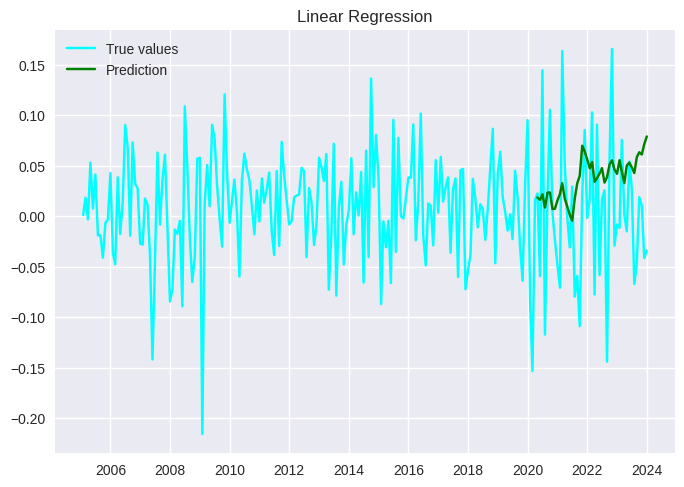

In [9]:
pca = PCA(n_components = 15)

# Fit and transform data
pca_features = pca.fit_transform(X_train)

# X = sm.add_constant(X)
model = sm.OLS(y_train, pca_features)
results = model.fit()
# print(results.summary())

# Assuming test_data is your new data
predictions = results.predict(pca.transform(X_test))
print(f'RMSE of linear regression: {calculate_rmse(y_test, predictions)}')
print(f'MAPE of linear regression: {calculate_mape(y_test, predictions)}')

plt.plot(data['y'], color = 'cyan')
plt.plot(pd.DataFrame(predictions, index= y_test.index), color = 'green')
plt.legend(["True values", "Prediction"])
plt.title('Linear Regression')
plt.show()

In [10]:
# Using xgboost

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3, 6],
           'learning_rate': [0.05],
           'n_estimators': [700, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = XGBRegressor(seed = 20, objective ='reg:squarederror')
modl = GridSearchCV(estimator=xgbr,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=1)
modl.fit(X_train, y_train)
print("Best parameters:", modl.best_params_)
print("Lowest RMSE: ", (-modl.best_score_)**(1/2.0))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000}
Lowest RMSE:  0.053157479386197685


In [11]:
# Instantiate the XGBRegressor
xgb_model = XGBRegressor(**modl.best_params_)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the last row of the training data
xgb_predictions = xgb_model.predict(X_test)

RMSE of XGBRegressor: 0.06796842230819279
MAPE of XGBRegressor: 228.5658642738821


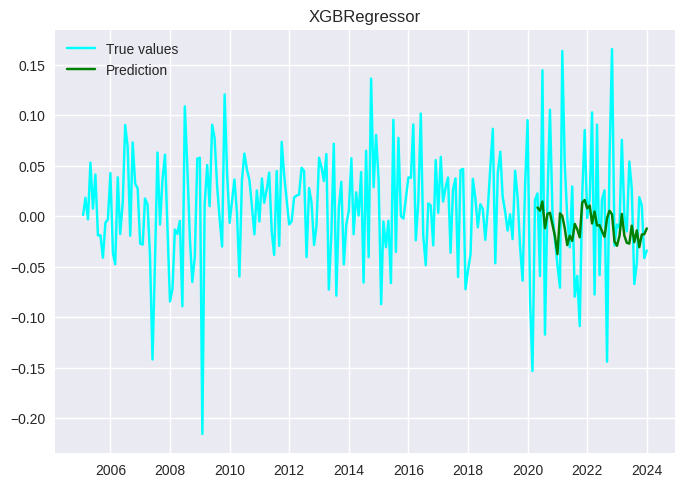

In [12]:
# Assuming test_data is your new data
print(f'RMSE of XGBRegressor: {calculate_rmse(y_test, xgb_predictions)}')
print(f'MAPE of XGBRegressor: {calculate_mape(y_test, xgb_predictions)}')

plt.plot(data['y'], color = 'cyan')

plt.plot(pd.DataFrame(xgb_predictions, index= y_test.index), color = 'green')
plt.title('XGBRegressor')
plt.legend(["True values", "Prediction"])
plt.show()

<Axes: >

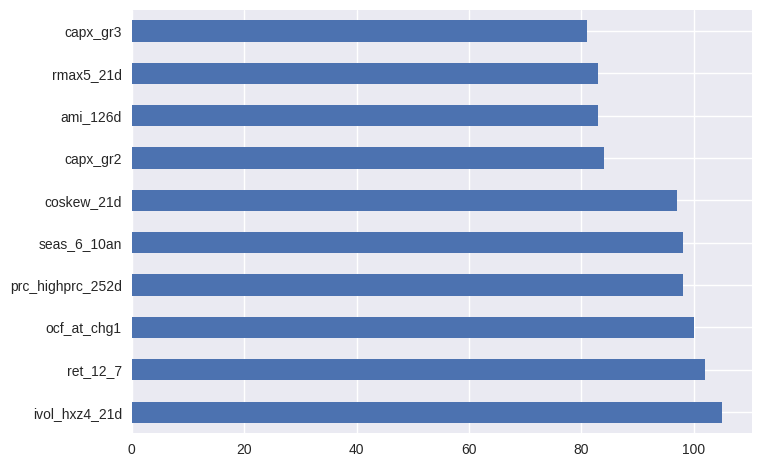

In [13]:
# Get feature importance
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')

pd.Series(feature_importance).sort_values(ascending=False).head(10).plot(kind='barh')

In [14]:
# Learning to rank
# --------------------------------------------------------------------------

# Prepare the features
X = features[features.index.get_level_values(1).isin([series_id])].reset_index(level=1, drop=True)
X.fillna(0, inplace=True)

# Prepare the labels
##  Aggregating returns to monthly frequency
return_series_monthly = np.exp(np.log(1 + return_series).resample('M').sum()) - 1

##  Compute the ranks for each row of the monthly return series DataFrame
## We multiply the returns by -1 to ensure that the rank is in ascending order (i.e. the highest return is ranked 1)
labels = (return_series_monthly * -1).rank(axis = 1)

# Add the features and labels (ranks) to the training data. Lag the labels by one month.
training_data = OptimizationData(align = True, lags = {'labels': -1}, X = X, labels = labels, qid = labels)


# ...
labels =

/tmp/ipykernel_3577/2608813872.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return_series_monthly = np.exp(np.log(1 + return_series).resample('M').sum()) - 1


In [25]:
features

,,ocf_at_chg1,capx_gr2,capx_gr3,niq_at_chg1,niq_be_chg1,prc_highprc_252d,sale_gr3,capex_abn,ami_126d,z_score,...,seas_1_1an,seas_1_1na,seas_11_15an,seas_11_15na,seas_16_20an,seas_16_20na,seas_2_5an,seas_2_5na,seas_6_10an,seas_6_10na
datadate,gvkey,,,,,,,,,,,,,,,,,,,,,
2005-01-31,149337,0.056069,-0.894434,-0.838719,0.000224,-0.025070,0.839216,-0.404049,-0.667650,0.258541,2.216092,...,0.007910,0.007192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-30,012785,-0.259307,-0.202476,-0.059797,0.010776,-0.188521,0.867609,0.437406,-0.301444,0.028630,2.207568,...,-0.562249,0.261819,-0.017856,0.019107,-0.034473,0.011873,-0.092032,-0.015119,-0.074788,0.036930
2009-05-31,012785,-0.342483,-0.003738,0.018717,-0.060742,-0.508179,0.180233,0.480856,-0.310662,0.106692,2.179904,...,-0.499775,0.094784,0.046941,0.023947,-0.036644,0.011322,0.020576,0.004926,0.094852,0.016249
2009-06-30,012785,-0.342483,-0.003738,0.018717,-0.060742,-0.508179,0.281285,0.480856,-0.310662,0.092487,2.179904,...,-0.061586,0.107030,0.056337,0.033990,0.075221,-0.001294,-0.012259,-0.005203,-0.010595,0.019036
2009-10-31,012785,-0.141422,-0.325987,-0.057055,0.029241,0.384622,0.809769,0.398072,-0.273433,0.018802,2.417377,...,0.055046,0.250755,0.053379,0.012577,-0.040146,0.015459,0.038789,-0.039756,0.129013,0.017722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,064690,-0.009183,0.770953,0.329455,-0.001423,-0.003132,0.949601,0.120641,0.259428,0.000172,2.783231,...,-0.135236,0.043451,0.009519,0.023055,-0.010209,0.009760,0.008319,0.005540,0.035310,0.009489
2023-09-30,064690,-0.009183,0.770953,0.329455,-0.001423,-0.003132,0.938704,0.120641,0.259428,0.000172,2.783231,...,0.205913,0.024304,-0.031142,0.030388,0.046575,0.002424,0.029548,0.001151,0.009532,0.009901
2023-10-31,064690,0.054624,0.579779,0.498876,-0.003693,-0.009535,0.891710,0.372833,0.129369,0.000174,2.816088,...,0.108401,0.009898,0.028716,0.032004,0.021299,-0.003731,0.068187,0.003194,0.055536,0.004636


In [15]:
labels

gvkey,001075,001078,001161,001209,001230,001300,001327,001380,001393,001440,...,158742,160211,160329,160479,160684,160776,160888,160991,161844,162129
datadate,,,,,,,,,,,,,,,,,,,,,
2005-01-31,332.0,282.0,492.0,104.0,453.0,105.0,485.0,51.0,208.0,89.0,...,483.0,359.0,110.0,270.0,350.0,358.0,486.0,93.0,434.0,124.0
2005-02-28,329.0,246.0,64.0,140.0,452.0,147.0,448.0,31.0,388.0,446.0,...,491.0,240.0,440.0,119.0,63.0,412.0,488.0,196.0,65.0,338.0
2005-03-31,143.0,158.0,452.0,150.0,75.0,286.0,485.0,354.0,76.0,139.0,...,402.0,19.0,360.0,250.0,424.0,474.0,1.0,135.0,412.0,80.0
2005-04-30,187.0,48.0,445.0,359.0,416.0,287.0,478.0,249.0,201.0,94.0,...,17.0,252.0,3.0,282.0,482.0,356.0,405.0,199.0,475.0,493.0
2005-05-31,214.0,443.0,41.0,314.0,90.0,335.0,16.0,417.0,38.0,322.0,...,494.0,6.0,7.0,86.0,486.0,408.0,485.0,219.0,459.0,340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,240.0,294.0,165.0,195.0,449.0,133.0,418.0,101.0,226.0,221.0,...,446.0,138.0,215.0,255.0,244.0,494.0,441.0,351.0,486.0,371.0
2023-10-31,101.0,192.0,264.0,158.0,452.0,174.0,432.0,320.0,408.0,138.0,...,147.0,415.0,306.0,453.0,361.0,493.0,266.0,80.0,62.0,383.0
2023-11-30,409.0,191.0,27.0,461.0,48.0,263.0,143.0,449.0,95.0,290.0,...,138.0,87.0,286.0,17.0,159.0,1.0,22.0,162.0,446.0,186.0


In [19]:
from sklearn.datasets import make_classification
import numpy as np

import xgboost as xgb

# Make a synthetic ranking dataset for demonstration
seed = 1994
X, y = make_classification(random_state=seed)
rng = np.random.default_rng(seed)
n_query_groups = 3
qid = rng.integers(0, n_query_groups, size=X.shape[0])

# Sort the inputs based on query index
sorted_idx = np.argsort(qid)
X = X[sorted_idx, :]
y = y[sorted_idx]
qid = qid[sorted_idx]

In [16]:
from xgboost import XGBRanker
ranker = XGBRanker(tree_method="hist", objective="rank:ndcg")
# NDCG stands for Normalized Discounted Cumulative Gain.